In [1]:
import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import pandas as pd 
import pandas_datareader.data as web
import datetime
import numpy as np 
from matplotlib import style

# ignore warnings 
import warnings
warnings.filterwarnings('ignore')

c:\Users\prath\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
style.use('ggplot')
data = pd.read_csv('historic_data/csv/TCS.NS.csv')
train_size = int(len(data) * 0.8) 
train_df = data[:train_size].dropna(how='any', axis=0)
test_df = data[train_size:].dropna(how='any', axis=0)


test_df.tail()



,Date,Low,Open,Volume,High,Close,Adjusted Close
5150,25-04-2023,3147.500000,3183.000000,2024090.0,3191.199951,3176.000000,3176.000000
5151,26-04-2023,3181.000000,3181.000000,2000029.0,3208.399902,3198.149902,3198.149902
5152,27-04-2023,3170.649902,3185.000000,2434446.0,3199.199951,3187.949951,3187.949951
5153,28-04-2023,3196.250000,3200.399902,2931312.0,3227.250000,3219.250000,3219.250000
5154,02-05-2023,3210.000000,3235.000000,2320980.0,3235.000000,3219.399902,3219.399902


In [3]:
train_df['Date'] = pd.to_datetime(train_df['Date'], format='%d-%m-%Y')
train_df['Date'] = train_df['Date'].dt.strftime('%Y-%m-%d')

test_df['Date'] = pd.to_datetime(test_df['Date'], format='%d-%m-%Y')
test_df['Date'] = test_df['Date'].dt.strftime('%Y-%m-%d')


#sort by date
train_df = train_df.sort_values('Date')
test_df = test_df.sort_values('Date')

# fix the date 
train_df.reset_index(inplace=True)
train_df.set_index("Date", inplace=True)
test_df.reset_index(inplace=True)
test_df.set_index("Date", inplace=True)

test_df.tail()

,index,Low,Open,Volume,High,Close,Adjusted Close
Date,,,,,,,
2023-04-25,5150,3147.500000,3183.000000,2024090.0,3191.199951,3176.000000,3176.000000
2023-04-26,5151,3181.000000,3181.000000,2000029.0,3208.399902,3198.149902,3198.149902
2023-04-27,5152,3170.649902,3185.000000,2434446.0,3199.199951,3187.949951,3187.949951
2023-04-28,5153,3196.250000,3200.399902,2931312.0,3227.250000,3219.250000,3219.250000
2023-05-02,5154,3210.000000,3235.000000,2320980.0,3235.000000,3219.399902,3219.399902


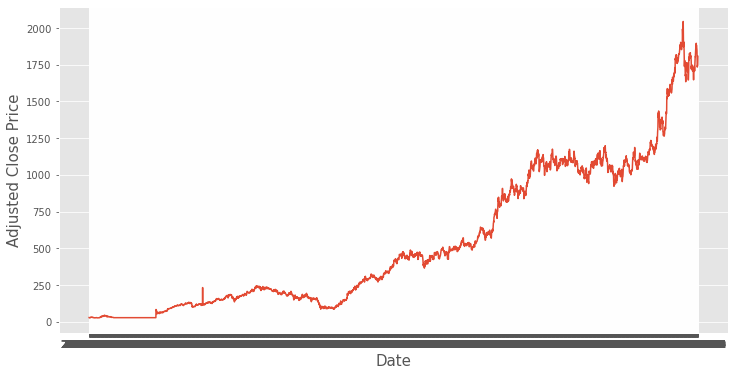

In [4]:
# Visualize the training stock data:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (12,6))
plt.plot(train_df["Adjusted Close"])
plt.xlabel('Date',fontsize=15)
plt.ylabel('Adjusted Close Price',fontsize=15)
plt.show()

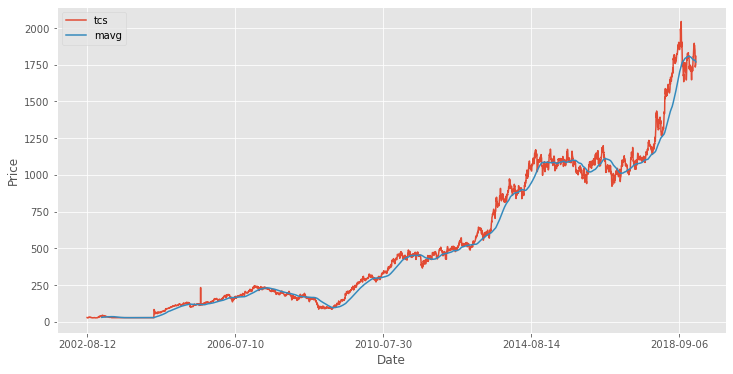

In [5]:
# Rolling mean
close_px = train_df['Adjusted Close']
mavg = close_px.rolling(window=100).mean()

plt.figure(figsize = (12,6))
close_px.plot(label='tcs')
mavg.plot(label='mavg')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

In [6]:
import matplotlib.dates as mdates

# change the dates into ints for training 
train_dates_df = train_df.copy()
train_dates_df = train_dates_df.reset_index()

train_dates_df['Date'] = pd.to_datetime(train_dates_df['Date'])

# change the dates into ints for testing 
test_dates_df = test_df.copy()
test_dates_df = test_dates_df.reset_index()

test_dates_df['Date'] = pd.to_datetime(test_dates_df['Date'])


# Store the original dates for plotting the predicitons
train_org_dates = train_dates_df['Date']
test_org_dates = test_dates_df['Date']

# convert to ints
train_dates_df['Date'] = train_dates_df['Date'].map(mdates.date2num)
test_dates_df['Date'] = test_dates_df['Date'].map(mdates.date2num)
test_dates_df.tail()

,Date,index,Low,Open,Volume,High,Close,Adjusted Close
1026,19472.0,5150,3147.500000,3183.000000,2024090.0,3191.199951,3176.000000,3176.000000
1027,19473.0,5151,3181.000000,3181.000000,2000029.0,3208.399902,3198.149902,3198.149902
1028,19474.0,5152,3170.649902,3185.000000,2434446.0,3199.199951,3187.949951,3187.949951
1029,19475.0,5153,3196.250000,3200.399902,2931312.0,3227.250000,3219.250000,3219.250000
1030,19479.0,5154,3210.000000,3235.000000,2320980.0,3235.000000,3219.399902,3219.399902


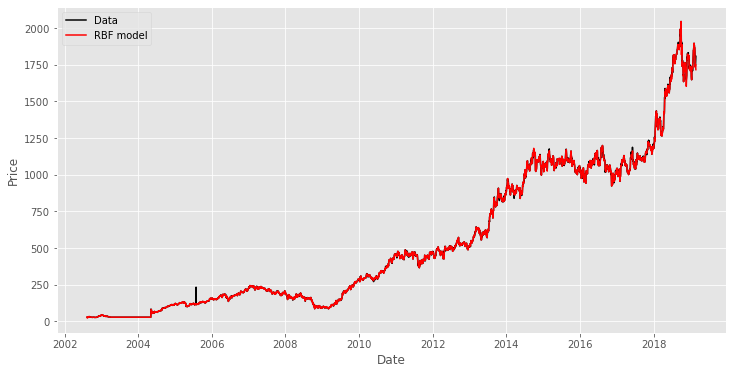

In [7]:
# Use sklearn support vector regression to predict our data:
from sklearn.svm import SVR

dates = train_dates_df['Date'].to_numpy()
prices = train_df['Adjusted Close'].to_numpy()

# Convert to 1d Vector
dates = np.reshape(dates, (len(dates), 1))
prices = np.reshape(prices, (len(prices), 1))

svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_rbf.fit(dates, prices)

plt.figure(figsize=(12, 6))
plt.plot(dates, prices, color='black', label='Data')
plt.plot(train_org_dates, svr_rbf.predict(dates), color='red', label='RBF model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [8]:
train_data = train_df.iloc[-1000:, train_df.columns.get_loc('Adjusted Close')].to_numpy()
print(train_data.shape)

(1000,)


In [9]:
# Apply normalization before feeding to LSTM using sklearn:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
# print(train_data)
scaler.fit(train_data)
train_data = scaler.transform(train_data)
print(train_data)

[[0.15001973]
 [0.126312  ]
 [0.09924637]
 [0.10631932]
 [0.1071682 ]
 [0.1360627 ]
 [0.15343329]
 [0.1726147 ]
 [0.18974042]
 [0.18766548]
 [0.1956246 ]
 [0.19868053]
 [0.186402  ]
 [0.18046074]
 [0.18268639]
 [0.18534556]
 [0.22555696]
 [0.2142405 ]
 [0.19554968]
 [0.17682059]
 [0.17527398]
 [0.16163771]
 [0.16635366]
 [0.15250928]
 [0.14494616]
 [0.15301826]
 [0.14383339]
 [0.15775247]
 [0.16329751]
 [0.16563657]
 [0.15588521]
 [0.14926513]
 [0.12638746]
 [0.12702833]
 [0.14564379]
 [0.14179639]
 [0.13753375]
 [0.13928804]
 [0.15350886]
 [0.17478392]
 [0.18351646]
 [0.17944235]
 [0.18010247]
 [0.16963489]
 [0.15267934]
 [0.11195863]
 [0.09458805]
 [0.09392783]
 [0.10073666]
 [0.10531942]
 [0.11882401]
 [0.12152069]
 [0.11955981]
 [0.11665512]
 [0.10775286]
 [0.1144858 ]
 [0.12817893]
 [0.10750723]
 [0.13851463]
 [0.13172471]
 [0.14256959]
 [0.13008393]
 [0.12725492]
 [0.12116253]
 [0.12565134]
 [0.12914078]
 [0.12623643]
 [0.14296581]
 [0.14238094]
 [0.16591917]
 [0.1595445 ]
 [0.16

In [10]:
'''Function to create a dataset to feed into an LSTM'''
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [11]:
# Create the data to train our model on:
time_steps = 36
X_train, y_train = create_dataset(train_data, time_steps)
print(train_data.shape)
# reshape it [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 36, 1))


(1000, 1)


In [12]:
# Visualizing our data with prints: 
print('X_train:')
print(str(scaler.inverse_transform(X_train[0])))
print("\n")
print('y_train: ' + str(scaler.inverse_transform(y_train[0].reshape(-1,1)))+'\n')

X_train:
[[1090.79296875]
 [1064.17712402]
 [1033.79150391]
 [1041.73205566]
 [1042.68505859]
 [1075.12390137]
 [1094.62524414]
 [1116.1595459 ]
 [1135.38598633]
 [1133.05651855]
 [1141.99194336]
 [1145.42272949]
 [1131.63806152]
 [1124.96801758]
 [1127.4666748 ]
 [1130.45202637]
 [1175.59594727]
 [1162.89135742]
 [1141.90783691]
 [1120.88134766]
 [1119.14501953]
 [1103.83605957]
 [1109.13049316]
 [1093.58789062]
 [1085.0970459 ]
 [1094.15930176]
 [1083.84777832]
 [1099.47424316]
 [1105.69946289]
 [1108.32543945]
 [1097.37792969]
 [1089.94580078]
 [1064.26184082]
 [1064.98132324]
 [1085.88024902]
 [1081.56091309]]


y_train: [[1076.77539062]]



## Preparing our data for the neural network: 
* Here we create the 'create_dataset' function. This function loops from (0 to our dataset length - the number of time steps). 
* So essentially each index in the X_train array contains an array of 36 days of closing prices and the y_train array contains the closing price one day after our time steps. 
* So, in other words, we feed the neural network 36 days of the previous closing prices of stock data and then have it predict the next day of the closing stock price. 

In [13]:
# Build the model 
model = keras.Sequential()

model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 100))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units = 1))

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the model to the Training set
history = model.fit(X_train, y_train, epochs = 50, batch_size = 10, validation_split=.20)

Epoch 1/50
78/78 [==============================] - 55s 241ms/step - loss: 0.0034 - val_loss: 0.0105
Epoch 2/50
78/78 [==============================] - 10s 127ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 3/50
78/78 [==============================] - 11s 139ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 4/50
78/78 [==============================] - 10s 129ms/step - loss: 9.8841e-04 - val_loss: 0.0017
Epoch 5/50
78/78 [==============================] - 10s 126ms/step - loss: 9.6574e-04 - val_loss: 0.0016
Epoch 6/50
78/78 [==============================] - 10s 128ms/step - loss: 8.4549e-04 - val_loss: 0.0046
Epoch 7/50
78/78 [==============================] - 9s 121ms/step - loss: 8.0217e-04 - val_loss: 0.0012
Epoch 8/50
78/78 [==============================] - 11s 138ms/step - loss: 7.6100e-04 - val_loss: 0.0041
Epoch 9/50
78/78 [==============================] - 12s 151ms/step - loss: 7.8690e-04 - val_loss: 9.4243e-04
Epoch 10/50
78/78 [==============================] - 11s 141ms/s

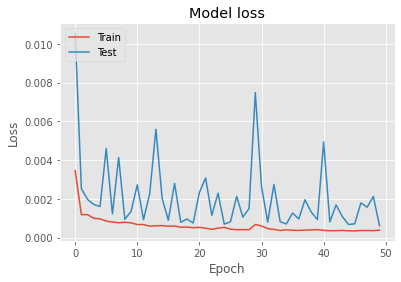

In [14]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [15]:
# Get the stock prices for 2019 to have our model make the predictions
test_data = test_df['Adjusted Close'].values
print(test_data)
test_data = test_data.reshape(-1,1)
test_data = scaler.transform(test_data)

# Create the data to test our model on:
time_steps = 36
X_test, y_test = create_dataset(test_data, time_steps)

# store the original vals for plotting the predictions 
y_test = y_test.reshape(-1,1)
org_y = scaler.inverse_transform(y_test)

# reshape it [samples, time steps, features]
X_test = np.reshape(X_test, (X_test.shape[0], 36, 1))

# Predict the prices with the model
predicted_y = model.predict(X_test)
predicted_y = scaler.inverse_transform(predicted_y)

[1856.28857422 1873.95263672 1805.98193359 ... 3187.94995117 3219.25
 3219.39990234]
32/32 [==============================] - 13s 67ms/step


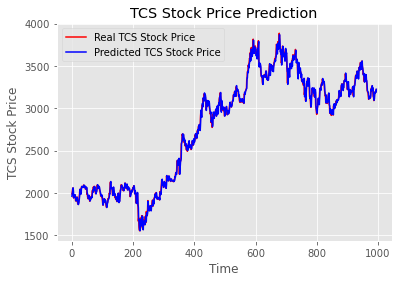

In [16]:
plt.plot(org_y, color = 'red', label = 'Real TCS Stock Price')
plt.plot(predicted_y, color = 'blue', label = 'Predicted TCS Stock Price')
plt.title('TCS Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TCS Stock Price')

plt.legend()
plt.show()


In [17]:
# Get the latest stock price data
latest_data = data

# Extract the 'Adjusted Close' column
latest_prices = latest_data['Adjusted Close'].values

# Scale the data
latest_prices = latest_prices.reshape(-1,1)
latest_prices = scaler.transform(latest_prices)

# Reshape the data for prediction
X_today = latest_prices[-time_steps:]
X_today = np.reshape(X_today, (1, time_steps, 1))

# Predict the stock price for tomorrow
predicted_price = model.predict(X_today)
predicted_price = scaler.inverse_transform(predicted_price)

# Get the latest price for today
latest_price_today = scaler.inverse_transform(latest_prices[-1].reshape(-1,1))[0][0]

# Print the latest price for today and the predicted price for tomorrow
print('The latest stock price for today is:', latest_price_today)
print('The predicted stock price for tomorrow is:', predicted_price[0][0])


1/1 [==============================] - 0s 243ms/step
The latest stock price for today is: 3219.39990234375
The predicted stock price for tomorrow is: 3223.1677


In [18]:
import pickle
with open('lstm.pkl', 'wb') as f:
    pickle.dump((latest_price_today, predicted_price[0][0]), f)